In [1]:
from pathlib import Path

ROOT_DIR = Path().resolve().parent
DATA_DIR = ROOT_DIR / 'data' / 'raw'

json_file = DATA_DIR / 'arxiv_manifest' / 'arxiv-metadata-oai-snapshot.json'
json_file

WindowsPath('C:/Users/User/Documents/Projects/Python-projects/Work/MLScienceTrend-Analysis/data/raw/arxiv_manifest/arxiv-metadata-oai-snapshot.json')

In [2]:
import sparknlp

spark = sparknlp.start()

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

Spark NLP version 3.3.0
Apache Spark version: 3.1.1


In [3]:
arxiv_df = spark.read.json(json_file.resolve().as_posix())
arxiv_df.printSchema()

root
 |-- abstract: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- authors_parsed: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- categories: string (nullable = true)
 |-- comments: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- id: string (nullable = true)
 |-- journal-ref: string (nullable = true)
 |-- license: string (nullable = true)
 |-- report-no: string (nullable = true)
 |-- submitter: string (nullable = true)
 |-- title: string (nullable = true)
 |-- update_date: string (nullable = true)
 |-- versions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- created: string (nullable = true)
 |    |    |-- version: string (nullable = true)



In [4]:
columns = ['abstract', 'categories']

arxiv_df.select(columns).show(truncate=50)

+--------------------------------------------------+-----------------+
|                                          abstract|       categories|
+--------------------------------------------------+-----------------+
|  A fully differential calculation in perturbat...|           hep-ph|
|  We describe a new algorithm, the $(k,\ell)$-p...|    math.CO cs.CG|
|  The evolution of Earth-Moon system is describ...|   physics.gen-ph|
|  We show that a determinant of Stirling cycle ...|          math.CO|
|  In this paper we show how to compute the $\La...|  math.CA math.FA|
|  We study the two-particle wave function of pa...|cond-mat.mes-hall|
|  A rather non-standard quantum representation ...|            gr-qc|
|  A general formulation was developed to repres...|cond-mat.mtrl-sci|
|  We discuss the results from the combined IRAC...|         astro-ph|
|  Partial cubes are isometric subgraphs of hype...|          math.CO|
|  In this paper we present an algorithm for com...|  math.NT math.AG|
|  Rec

In [5]:
from pyspark.sql.functions import col, size, split

arxiv_df.withColumn('cat_num', size(split(col("categories"), r" "))).select(columns + ['cat_num']).show(truncate=50)

+--------------------------------------------------+-----------------+-------+
|                                          abstract|       categories|cat_num|
+--------------------------------------------------+-----------------+-------+
|  A fully differential calculation in perturbat...|           hep-ph|      1|
|  We describe a new algorithm, the $(k,\ell)$-p...|    math.CO cs.CG|      2|
|  The evolution of Earth-Moon system is describ...|   physics.gen-ph|      1|
|  We show that a determinant of Stirling cycle ...|          math.CO|      1|
|  In this paper we show how to compute the $\La...|  math.CA math.FA|      2|
|  We study the two-particle wave function of pa...|cond-mat.mes-hall|      1|
|  A rather non-standard quantum representation ...|            gr-qc|      1|
|  A general formulation was developed to repres...|cond-mat.mtrl-sci|      1|
|  We discuss the results from the combined IRAC...|         astro-ph|      1|
|  Partial cubes are isometric subgraphs of hype...|

<AxesSubplot:xlabel='cat_num'>

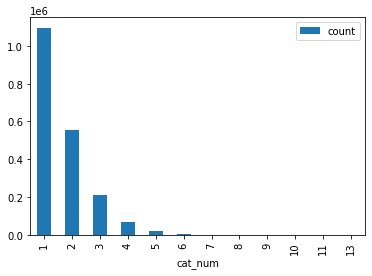

In [6]:
import pyspark.sql.functions as F

cats_num = arxiv_df.withColumn('cat_num', size(split(col("categories"), r" ")))\
    .groupBy("cat_num") \
    .count() \
    .orderBy(F.col("count").desc()) \
    .toPandas()


cats_num.plot.bar(x='cat_num', y='count')

In [7]:
import requests
from bs4 import BeautifulSoup
import re

cats = {}

pat = re.compile(r"\/(list|archive)\/(.+)\/(new|recent)?")

r = requests.get("https://arxiv.org/")
if r.status_code == 200:
    soup = BeautifulSoup(r.content, "html.parser")
    for title, bullet_pt in zip(soup.select("div#content h2"), soup.select("div#content h2 ~ ul")):
        print(title.text)
        cats[title.text] = []
        for pt in bullet_pt.select('li'):
            for href in [link['href'] for link in pt.find_all("a")]:
                match = pat.search(href)
                if match:
                    print(match.group(2))
                    cats[title.text].append(match.group(2))
        print("=================")

Physics
astro-ph
astro-ph
astro-ph.GA
astro-ph.CO
astro-ph.EP
astro-ph.HE
astro-ph.IM
astro-ph.SR
cond-mat
cond-mat
cond-mat.dis-nn
cond-mat.mtrl-sci
cond-mat.mes-hall
cond-mat.other
cond-mat.quant-gas
cond-mat.soft
cond-mat.stat-mech
cond-mat.str-el
cond-mat.supr-con
gr-qc
gr-qc
hep-ex
hep-ex
hep-lat
hep-lat
hep-ph
hep-ph
hep-th
hep-th
math-ph
math-ph
nlin
nlin
nlin.AO
nlin.CG
nlin.CD
nlin.SI
nlin.PS
nucl-ex
nucl-ex
nucl-th
nucl-th
physics
physics
physics.acc-ph
physics.app-ph
physics.ao-ph
physics.atm-clus
physics.atom-ph
physics.bio-ph
physics.chem-ph
physics.class-ph
physics.comp-ph
physics.data-an
physics.flu-dyn
physics.gen-ph
physics.geo-ph
physics.hist-ph
physics.ins-det
physics.med-ph
physics.optics
physics.soc-ph
physics.ed-ph
physics.plasm-ph
physics.pop-ph
physics.space-ph
quant-ph
quant-ph
Mathematics
math
math
math.AG
math.AT
math.AP
math.CT
math.CA
math.CO
math.AC
math.CV
math.DG
math.DS
math.FA
math.GM
math.GN
math.GT
math.GR
math.HO
math.IT
math.KT
math.LO
math.MP
math

In [8]:
# Do a simple model with unique categories

arxiv_df.select(columns)\
    .filter(size(split(col("categories"), r" ")) == 1)\
    .show(truncate=50)

+--------------------------------------------------+-----------------+
|                                          abstract|       categories|
+--------------------------------------------------+-----------------+
|  A fully differential calculation in perturbat...|           hep-ph|
|  The evolution of Earth-Moon system is describ...|   physics.gen-ph|
|  We show that a determinant of Stirling cycle ...|          math.CO|
|  We study the two-particle wave function of pa...|cond-mat.mes-hall|
|  A rather non-standard quantum representation ...|            gr-qc|
|  A general formulation was developed to repres...|cond-mat.mtrl-sci|
|  We discuss the results from the combined IRAC...|         astro-ph|
|  Partial cubes are isometric subgraphs of hype...|          math.CO|
|  Recently, Bruinier and Ono classified cusp fo...|          math.NT|
|  Serre obtained the p-adic limit of the integr...|          math.NT|
|  The pure spinor formulation of the ten-dimens...|           hep-th|
|  In 

In [11]:
# Another example
import pandas as pd
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import pandas_udf

def find_alias(cat: str, cat_dict = cats) -> str:
    for k, v in cats.items():
        if v[0] in cat:
            return k
        
    return "No cat"

@pandas_udf('string')
def replace_cat(s: pd.Series) -> pd.Series:
    return s.apply(lambda x: find_alias(x))



arxiv_df_2 =arxiv_df.select(columns)\
    .filter(size(split(col("categories"), r" ")) == 1)\
    .withColumn('simple_cats', replace_cat())\
    .select(columns + ['simple_cats'])\
    .show(truncate=50)

arxiv_df_2.show()

Py4JJavaError: An error occurred while calling o143.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 9.0 failed 1 times, most recent failure: Lost task 0.0 in stage 9.0 (TID 463) (DESKTOP-0V4EL69 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:182)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec.evaluate(ArrowEvalPythonExec.scala:88)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:130)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:458)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:174)
	... 24 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2223)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2242)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:472)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:425)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:47)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3696)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:772)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2929)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:301)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:338)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:182)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec.evaluate(ArrowEvalPythonExec.scala:88)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:130)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:458)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:174)
	... 24 more


In [15]:
simple_cats = {}

for k, v in cats.items():
    s_cats = set([val.split('.')[0] for val in v])
    
    if list(s_cats):
        simple_cats[k] = list(s_cats)
    
simple_cats

{'Physics': ['hep-lat',
  'cond-mat',
  'nucl-ex',
  'physics',
  'hep-ex',
  'nucl-th',
  'hep-ph',
  'math-ph',
  'hep-th',
  'nlin',
  'astro-ph',
  'quant-ph',
  'gr-qc'],
 'Mathematics': ['math'],
 'Computer Science': ['cs'],
 'Quantitative Biology': ['q-bio'],
 'Quantitative Finance': ['q-fin'],
 'Statistics': ['stat'],
 'Electrical Engineering and Systems Science': ['eess'],
 'Economics': ['econ']}

In [ ]:


arxiv_df.withColumn('super_categories', upper(df.c)).show()